<a href="https://colab.research.google.com/github/andyboat75/Energy-Efficient-Distributed-System/blob/main/Heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 9.5MB 23.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import date, datetime
import time

import math
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import warnings
warnings.filterwarnings('ignore')

## Accessing Data from Gdrive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/Colab Notebooks/Heart')

# Data Cleaning and Exploratory Data Analysis

In [ ]:
df = pd.read_csv('heartrate_seconds_merged.csv')
df.Time = pd.to_datetime(df.Time)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483658 entries, 0 to 2483657
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Id      int64         
 1   Time    datetime64[ns]
 2   Value   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 56.8 MB


In [ ]:
df.isnull().sum()

Id       0
Time     0
Value    0
dtype: int64

In [ ]:
df.describe()

,Id,Value
count,2.483658e+06,2.483658e+06
mean,5.513765e+09,7.732842e+01
std,1.950224e+09,1.940450e+01
min,2.022484e+09,3.600000e+01
25%,4.388162e+09,6.300000e+01
50%,5.553957e+09,7.300000e+01
75%,6.962181e+09,8.800000e+01
max,8.877689e+09,2.030000e+02


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483658 entries, 0 to 2483657
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Id      int64         
 1   Time    datetime64[ns]
 2   Value   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 56.8 MB


In [ ]:
df.drop(['Id'], axis=1, inplace=True)
df.Time = sorted(df.Time)
df.head()

,Time,Value
0,2016-04-12 00:00:00,97
1,2016-04-12 00:00:00,102
2,2016-04-12 00:00:01,105
3,2016-04-12 00:00:03,103
4,2016-04-12 00:00:05,101


In [ ]:
df.tail()

,Time,Value
2483653,2016-05-12 16:19:25,57
2483654,2016-05-12 16:19:30,56
2483655,2016-05-12 16:19:40,55
2483656,2016-05-12 16:19:50,55
2483657,2016-05-12 16:20:00,56


In [ ]:
sections = [(i-int(len(df)/4),i) for i in range(int(len(df)/4), len(df), int(len(df)/4))]

In [ ]:
df1,df2,df3,df4 = (df[i:j] for i,j in sections)

In [ ]:
# try dividing df into 2
mid = int(len(df)/2)+1
df2_1 = df[:mid]
df2_2 = df[mid:]

In [ ]:
# since I have divided the data into four sections above. The logic is that all the analysis after this cell should for all data sections.
# just change the variable data below  to the name of the section.
data = df2_1.copy()

In [ ]:
# checking the time interval which appears to be in 1 second as opposed to the 1 minutes said on the site
# data['Time_interval'] = data.Time - data.Time.shift(1)
# data[['Time', 'Time_interval']][:15]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241830 entries, 0 to 1241829
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Time    1241830 non-null  datetime64[ns]
 1   Value   1241830 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 18.9 MB


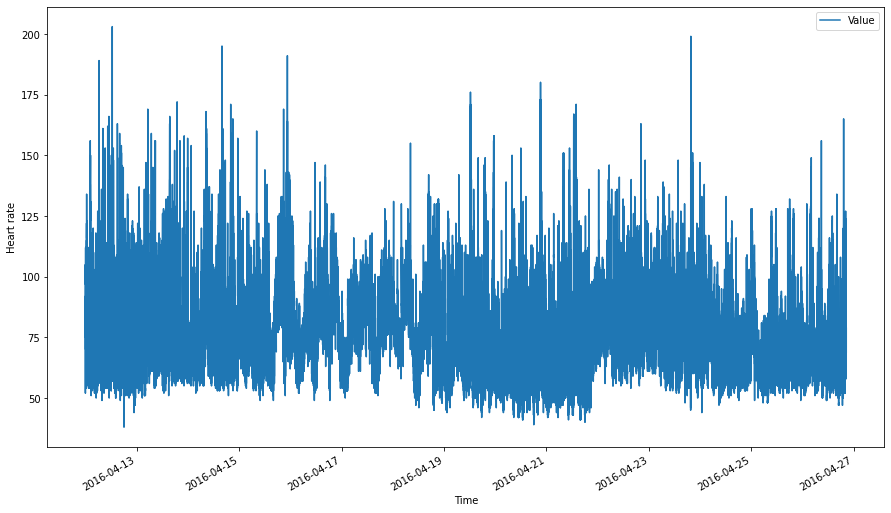

In [ ]:
data.set_index('Time').plot(figsize=(15,9))
plt.xlabel('Time')
plt.ylabel('Heart rate')
plt.show()

In [ ]:
target = 'Value'

# Stationary or Non Stationary And Seasonality

In this section, we will perform various test to check the stationarity of our time series. Such test will include Augmented Dickey Fuller test, Resampling and Rolling of Data.

We will lastly, perform seasonality check by decomposing our time series.


## Rolling Test

From the results below you can see that our time series is relatively stationary.
That is the mean and standard deviation is almost constant over time.

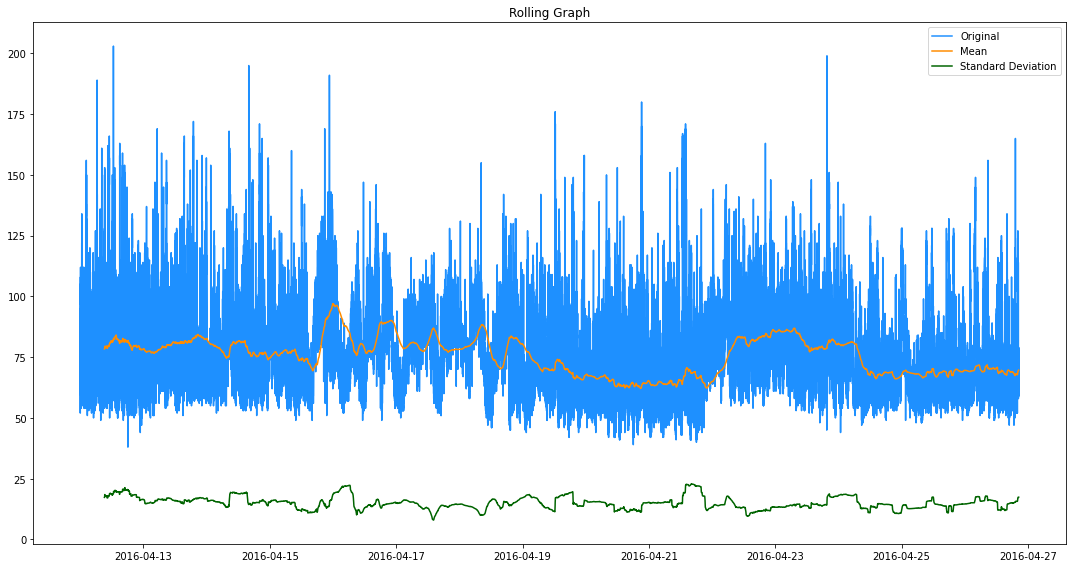

In [ ]:
rol_df = data.copy()
rol_df.set_index('Time', inplace=True)
rol_mean = rol_df.rolling(window=30000).mean() #window size 500 minutes = 60s * 500
rol_std = rol_df.rolling(window=30000).std()


f, ax = plt.subplots(figsize=(15,8))
ax.plot(rol_df.index, rol_df[target], color='dodgerblue', label='Original')
ax.plot(rol_mean.index, rol_mean[target], color='darkorange', label='Mean')
ax.plot(rol_std.index, rol_std[target], color='darkgreen', label='Standard Deviation')
ax.set_title(f'Rolling Graph')
plt.tight_layout()
plt.legend()
plt.savefig('Rolling.png')
plt.show()

## Resampling & ADF Test
From the results below it is evidently clear that our data is stationary.

In [ ]:
res_df = data.copy()

In [ ]:
# simple sampling function
def sampler(data, samp_freq):
    data['Timestamp'] = data['Time']
    data.index = data.Timestamp
    data = data.resample(samp_freq).mean()
    if (data.isna().sum()[0] > 0):
        data = data.fillna(method='bfill')
    return data

In [ ]:
# stationarity test function/ ADF test
def test_stationarity(data, target, samp_data):
    results = adfuller(data[target])
    # print(f"ACDF Statistics: {results[0]}")
    # print(f"p-value: {results[1]}")
    if results[1] > 0.05:
        print(f"{samp_data} sampled data: Non stationary")
        print(f"p-value: {results[1]}\n")
    else:
        print(f"{samp_data} sampled data: Stationary")
        print(f"p-value: {results[1]}\n")
    return results

In [ ]:
# # problem: missing values in data after sampling. Investigate below
# samp_data = data.copy()
# samp_data.set_index('Time', inplace=True)
# samp_data = samp_data.resample('1H').mean()
# samp_data.isna().sum() # 6585 missing points
# # data[data['Value'].isnull()].index.tolist() #get index list of missing points

# if (samp_data.isna().sum()[0]>0):
#     samp_data = samp_data.fillna(method='bfill')

=========ADF test results==========
2 Hours sampled data: Non stationary
p-value: 0.08273110784364301

179


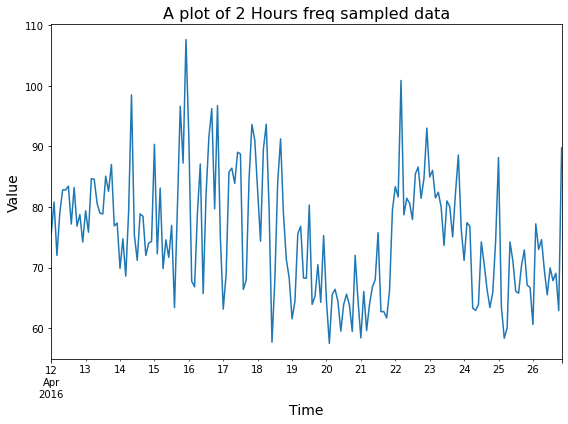

=========ADF test results==========
3 Hour sampled data: Non stationary
p-value: 0.3010124540917911

119


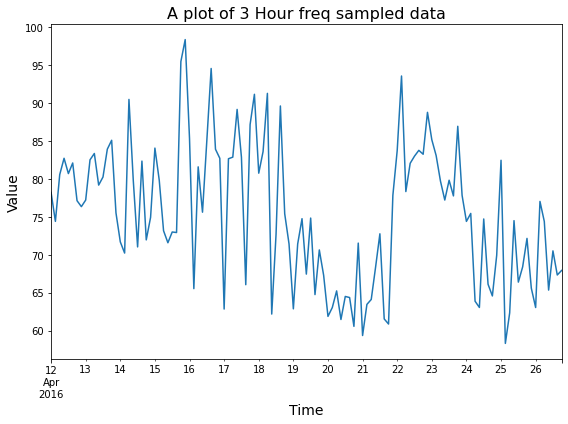

=========ADF test results==========
A Day sampled data: Non stationary
p-value: 0.07358666375782641

15


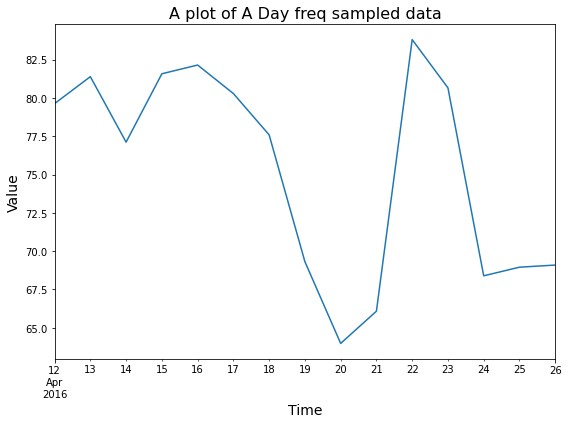

In [ ]:
# fig, ax = plt.subplots(figsize=(8,6))
sample_freq_dict = {'2H':'2 Hours','3H':'3 Hour','1D':'A Day'}
for i, freq in enumerate(sample_freq_dict.keys()):
    print("=========ADF test results==========")
    sampled_data = sampler(res_df, freq)
    adfc_test_results = test_stationarity(sampled_data, target=target, samp_data=sample_freq_dict[freq])
    sampled_data[target].plot(figsize=(8,6))
    print(len(sampled_data))
    plt.title(f'A plot of {sample_freq_dict[freq]} freq sampled data', fontsize=16)
    plt.ylabel(ylabel=target.capitalize(), fontsize=14)
    plt.xlabel(xlabel='Time', fontsize=14)
    plt.savefig(f'{sample_freq_dict[freq]}_resampled.png')
    # plt.legend()
    plt.tight_layout()
    plt.show()
    

ADF Test results

1 Hour is of length 357
1 Hour sampled data: Stationary
p-value: 4.670955150174982e-16

357
ADF Test results

3 Hour(s) is of length 119
3 Hour(s) sampled data: Non stationary
p-value: 0.30101245409179234

119
ADF Test results

2 Hour(s) is of length 179
2 Hour(s) sampled data: Non stationary
p-value: 0.0827311078436424

179


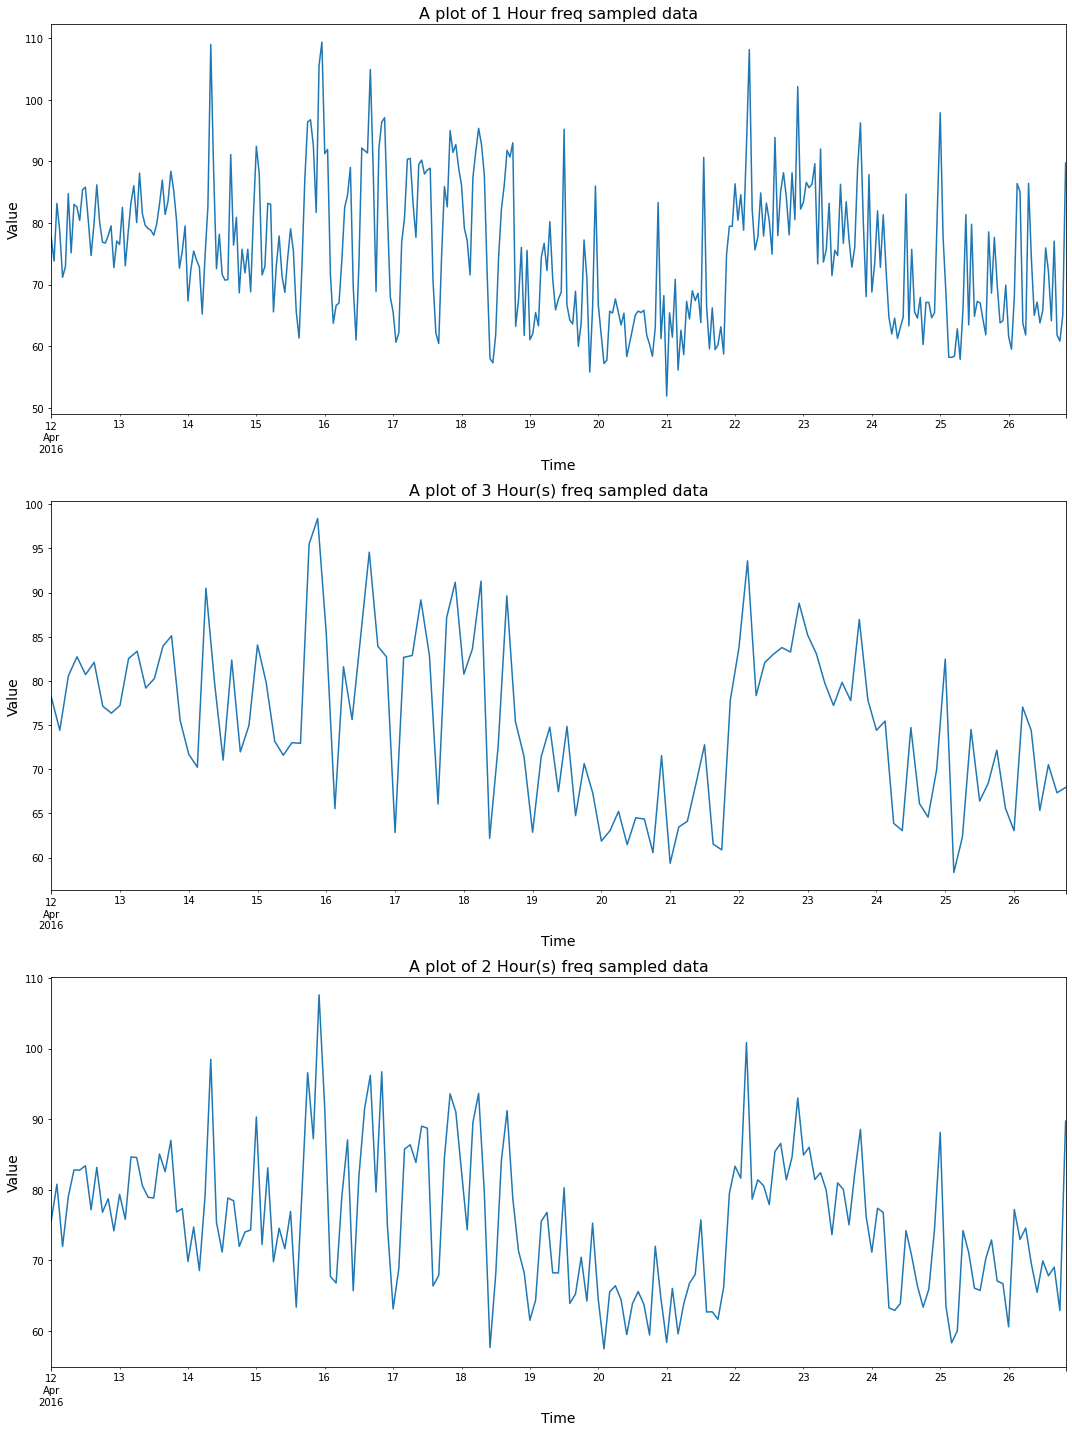

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
sample_freq_dict = {
    # '30T':'30 minutes',
    '1H':'1 Hour',
    '3H':'3 Hour(s)',
    '2H':'2 Hour(s)',
    # '12H':'Half a Day',
    # '1D':'a Day'
}
# sample_freq_dict = {'12H':'Half a Day', '1D':'a Day', '3D':'3 Days'}
for i, freq in enumerate(sample_freq_dict.keys()):
    sampled_data = sampler(res_df, freq)
    print('ADF Test results\n')
    print(f'{sample_freq_dict[freq]} is of length {len(sampled_data)}')
    adfc_test_results = test_stationarity(sampled_data, target=target, samp_data=sample_freq_dict[freq])
    sampled_data[target].plot(ax=ax[i])
    print(len(sampled_data))
    ax[i].set_title(f'A plot of {sample_freq_dict[freq]} freq sampled data', fontsize=16)
    ax[i].set_ylabel(ylabel=target.capitalize(), fontsize=14)
    ax[i].set_xlabel(xlabel='Time', fontsize=14)
    plt.savefig(f'{sample_freq_dict[freq]}_resampled.png')
    # plt.legend()
    # plt.show()
    plt.tight_layout()

In [ ]:
# final sampled data
sampled_data = sampler(data,'2H')

## Decomposition
We will now check for seasonality and trends in the data.

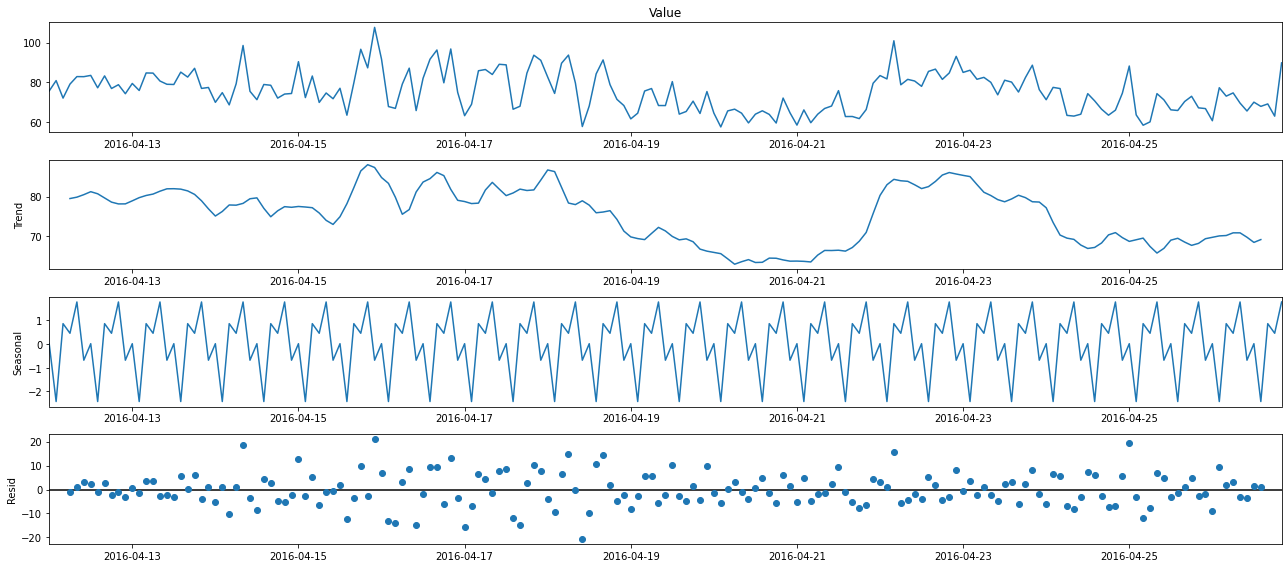

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(sampled_data[target], model='additive', freq=6)

decomp.plot()
plt.tight_layout()
plt.savefig('Decomposition_plot.png')
plt.show()

# ARIMA


In [ ]:
arima_df = sampled_data.copy()

## Plot of ACF and PACF

Note that since we have already concluded that it is stationary, we don't need to check the differencing order of arima. It is automatically zero. Our task now is to check the p of AR and q of MA

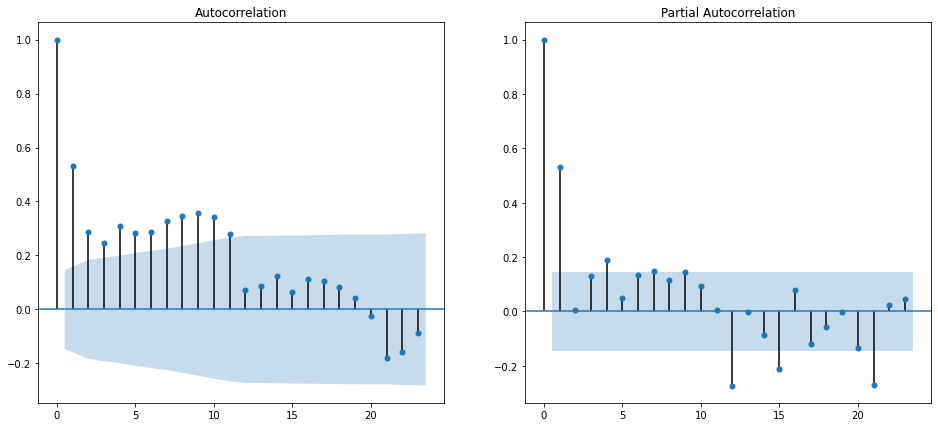

In [ ]:
# Since it is stationary d = 0
fig, ax = plt.subplots(1,2, figsize=(16,7))
# check p value of AR with pacf and q value of MA with ACF
# ax.set(ylim=(0,5))
plot_pacf(arima_df[target], ax=ax[1])
plot_acf(arima_df[target], ax=ax[0])
plt.savefig('ACF_PACF.png')
plt.show()

## Auto ARIMA
It is still not clear what p and q value will be from the PACF and ACF graphs above so we will use auto arima to help us in finding it

In [ ]:
auto_arima_model = pm.auto_arima(
    arima_df[target],
    m = 6, 
    d = None,    # differencing order
    # D = 0,
    max_p=3,
    max_q=3,
    trace=True,
    seasonal=True,
    error_action='ignore',
    stepwise=True,
    suppress_warnings=True,
    
)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1312.896, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1307.432, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1279.730, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1310.909, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=1278.044, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=1279.854, Time=0.12 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=1280.724, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=1267.441, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[6] intercept   : AIC=1269.441, Time=0.23 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=1269.441, Time=0.25 sec
 ARIMA(1,1,1)(1,0,1)[6] intercept   : AIC=1270.601, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=1305.778, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[6] intercept   : AIC=1263.805, Time=0.27 sec
 ARIMA(2,1,1)(1,0,0)[6] intercept   : 

## SARIMA DIAGONISTIC PLOT.
Top left plot: The residual errors fluctuate around a mean of zero.

Top right plot: The estimated density plot suggest a mean of zero and standard deviation of 1

Bottom Left: A scatter plot  with slight deviation from the red line

Bottom right: Correlogram/ACF plot.

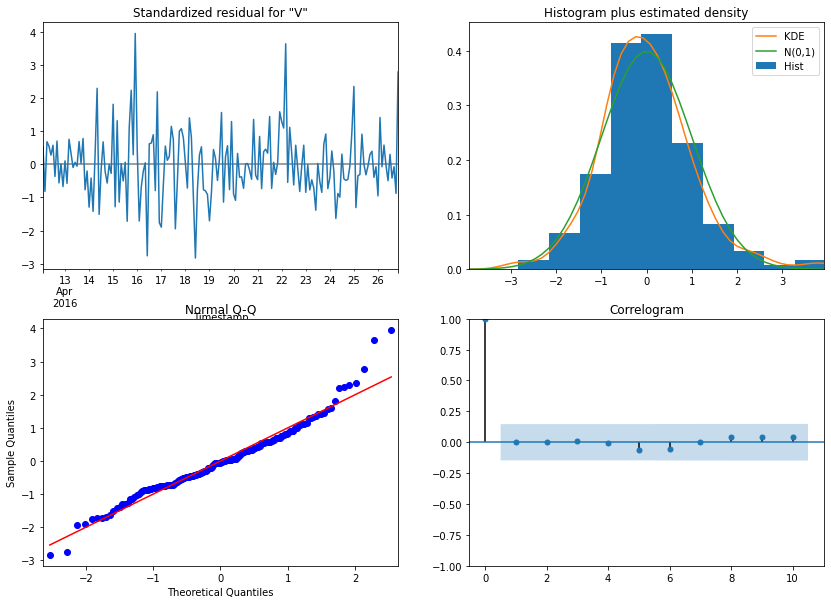

In [ ]:
# Fit model
smodel = SARIMAX(arima_df[target], 
                order=(2,1,4),
                seasonal_order=(0, 0, 0, 6))
results_1 = smodel.fit()

# Make plot of time series for comparison
results_1.plot_diagnostics(figsize=(14,10))
plt.savefig('SARIMAX_diagonistics.png')
plt.show()

In [ ]:
def main_arima(
    data,
    target,
    start_pred_from,
    order = (2, 1, 2),
    sorder = (0, 0, 0, 6), ):   

    

    # ===========================-
    # Train model
    # ===========================-
    model = SARIMAX(
        data[target],
        order = order,
        seasonal_order=sorder,
    )
    fit_stime = time.time()
    results = model.fit()
    fit_etime = time.time()
    print(f"Latency: {abs(fit_etime-fit_stime)}")


    # ===========================
    # Predict
    # ===========================
    pred_time = time.time()
    predictions = results.get_prediction(start = pd.to_datetime(start_pred_from), dynamic = False)
    pred_time = time.time()-pred_time    
    y_predictions = predictions.predicted_mean
    y_original = data[target][start_pred_from:]
    # confidence intervals
    conf_int = predictions.conf_int()
    # forecast dates
    dates = y_predictions.index
    # Calculate root_mse
    root_mse = np.sqrt(mean_squared_error(y_original, y_predictions))


    print('=====================-RESULTS:========================-')
    print(f'SARIMAX{order}x{sorder}')
    print(f'RMSE(test): {root_mse}')
    print(f'Prediction time: {pred_time} S')
    
    print(f'Prediction Horizon {abs(pd.to_datetime(start_pred_from) - data.index[-1])}')
    print('=====================================================================')


    # ===========================-
    # Plot Prediction
    # ===========================-

    fig, ax = plt.subplots(figsize=(12,7))
    # plt.figure(figsize=(12,6))
    # Plot past Appliances
    ax.plot(data[target].index, data[target], label='past')
    # Plot the prediction means as line
    ax.plot(dates, y_predictions, label='predicted')
    # Shade between the confidence intervals
    ax.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)


    # Plot legend and show figure
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Energy Consumption', fontsize=14)
    ax.set_title(f'SARIMAX{order}x{sorder}')
    plt.savefig(f'SARIMAX{order}x{sorder}_{start_pred_from}.png')
    plt.legend()
    plt.show()
    
    # Print last predicted mean
    print(y_predictions.iloc[-1])

    # Print last confidence interval
    print(conf_int.iloc[-1])
    
    return model

## Prediction plot

SARIMA (2,1,4)x(0,0,0,6)


In [ ]:
k = int(len(arima_df)*0.8)
st = arima_df.index[k]
print(st)
abs(st-arima_df.index[-1])

2016-04-23 22:00:00


Timedelta('2 days 22:00:00')

Latency: 0.20275664329528809
=====================-RESULTS:========================-
SARIMAX(2, 1, 2)x(0, 0, 0, 6)
RMSE(test): 7.344713921984137
Prediction time: 0.0013282299041748047 S
Prediction Horizon 2 days 22:00:00


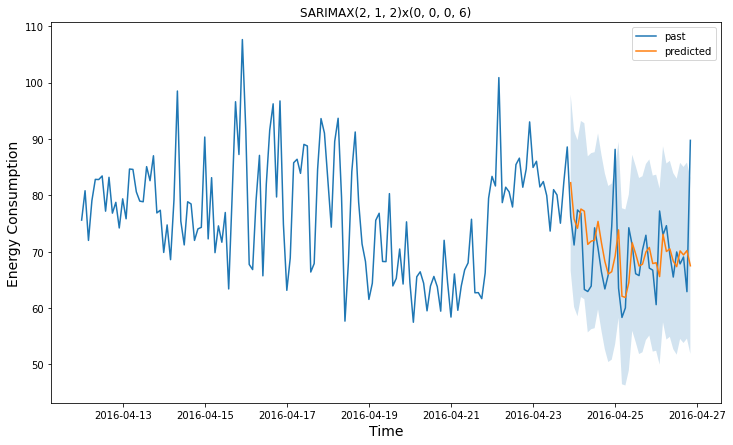

67.49263093986404
lower Value    51.875159
upper Value    83.110103
Name: 2016-04-26 20:00:00, dtype: float64


In [ ]:
model1 = main_arima(
    data = arima_df,
    target = target,
    start_pred_from = '2016-04-23 22:00:00',
    # order = (1, 0, 0),
    # sorder = (0, 0, 0, 6),
)

In [ ]:
model1 = main_arima(
    data = arima_df,
    target = target,
    start_pred_from = '2016-05-04 22:00:00',
    order = (1, 0, 0),
    sorder = (0, 0, 0, 6),
)

In [ ]:
model1 = main_arima(
    data = arima_df,
    target = target,
    start_pred_from = '2016-04-25 22:00:00',
    order = (2, 1, 3),
    sorder = (0, 0, 0, 6),
)

In [ ]:
def arima_fit(data,target=target, order=(2,1,4), seasonal_order=(0,0,0,6), forecast_step=30):
    # Fit model
    model = SARIMAX(data[target], 
                    order=order,
                    sorder=seasonal_order
                    )
    results_2 = model.fit()

    steps=forecast_step
    forecast = results_2.get_forecast(steps=steps)
    # predicted mean
    mean = forecast.predicted_mean
    # confidence intervals
    conf_int = forecast.conf_int()
    # forecast dates
    dates = mean.index

    plt.figure(figsize=(20,8))
    # Plot past Appliances
    plt.plot(data[target].index, data[target], label='past')
    # Plot the prediction means as line
    plt.plot(dates, mean, label='Forecast')
    # Shade between the confidence intervals
    plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.1)
    #lables
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Energy Consumption', fontsize=14)
    plt.title('Forecast: SARIMA', fontsize=15)
    # Plot legend and show figure
    plt.legend()
    plt.savefig(f'SARIMA:FORECAST{steps}.png')
    plt.show()
    # Print last predicted mean
    print(mean.iloc[-1])

    # Print last confidence interval
    print(conf_int.iloc[-1])

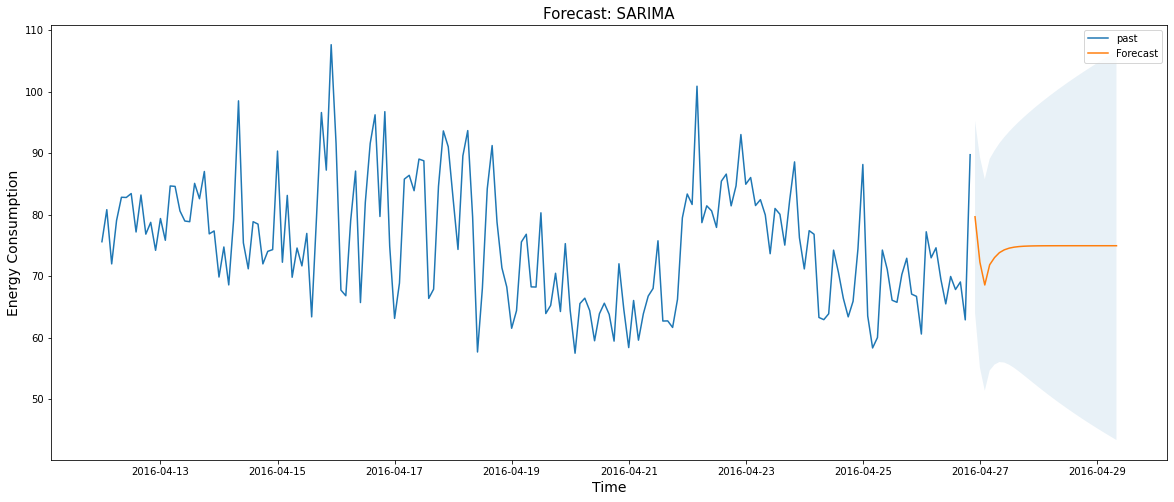

74.94283800262319
lower Value     43.359844
upper Value    106.525832
Name: 2016-04-29 08:00:00, dtype: float64


In [ ]:
arima_fit(arima_df,target)


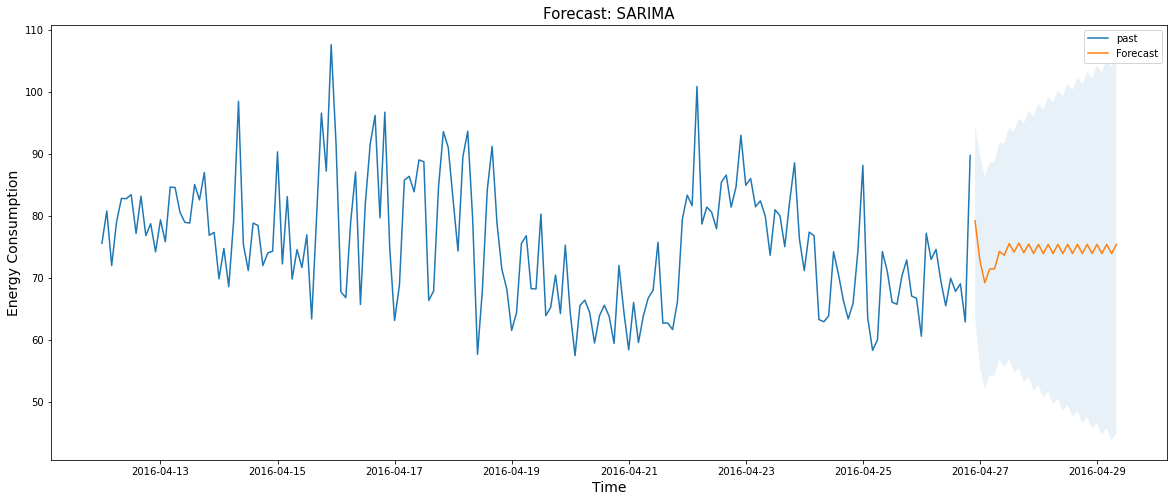

75.40920601171558
lower Value     44.901714
upper Value    105.916698
Name: 2016-04-29 08:00:00, dtype: float64


In [ ]:
arima_fit(arima_df,
          target,
          order=(3,1,4),
          seasonal_order=(1, 0, 1, 6))


# Long Short-Term Memory(LSTM) Network

In [ ]:
# create the necessary functions for LSTM Network model
def timeseries_to_supervised(data, lag=1):
    dframe = pd.DataFrame(data)
    columns = [dframe.shift(i) for i in range(1, lag+1)]
    columns.append(dframe)
    dframe = pd.concat(columns, axis=1)
    dframe.fillna(0, inplace=True)
    return dframe

# def supervised_to_timeseries(data, lag=1):
#     dframe = pd.Dataframe(data)
#     co


# transform timeseries to stationary
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history([-interval])


# scale train and test data to [-1,1]
def scale(train,test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    #transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    #transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def inv_array_scale(arr, scaler):
    inv_arr = timeseries_to_supervised(arr)
    inv_arr = scaler.inverse_transform(inv_arr)
    return inv_arr


# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


def inv_array_scale(arr, scaler):
    inv_arr = timeseries_to_supervised(arr)
    inv_arr = scaler.inverse_transform(inv_arr)
    return inv_arr

# LSTM model traning and testing
def fit_lstm(train, test, batch_size, nb_epoch, neurons):
    print(f"Parameters:")
    print(f"Epoch: {nb_epoch}\nBatch size: {batch_size}\nNeurons: {neurons}")
    x_train, y_train = train[:, 0:-1], train[:, -1]
    x_test, y_test = test[:, 0:-1], test[:,-1]
    #reshape
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    #model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    start_time = time.time()
    model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
              verbose=0, shuffle=False)
        # model.reset_states()
    end_time = time.time()
    print(f"Latency: {abs(start_time-end_time)}S")



    mse = model.evaluate(x_test, y_test, batch_size = batch_size)
    print('Evaluation')
    print(f'Mean square error: {mse}')
    

    # predictions = model.predict(x_test)
    return model


def main_lstm(batch_size,epc,nrns, tr_ratio):
    print("======================\nStarting Process\n======================")
    # to stationary error
    # diff_values = difference(lstm_df.values, interval=1)
    diff_values = dataset
    # print(diff_values.head())

    # to supervised works
    print("Transforming data to supervised data...")
    supervised = timeseries_to_supervised(diff_values)

    train_size = int(len(lstm_df)*tr_ratio)
    raw_train = lstm_df.values[:train_size]
    raw_test = lstm_df.values[train_size:]

    print(f"Train Size: {abs(lstm_df.index[0]-lstm_df.index[train_size])}")
    print(f"Prediction horizon: {abs(lstm_df.index[train_size]-lstm_df.index[-1])}")
    print("Spliting data into train and test sets...")
    # split into train and test sets
    train, test = supervised.values[:train_size], supervised.values[train_size:]
    # transform to scaled data
    print("Scaling data...")
    scaler, train_scaled, test_scaled = scale(train,test)
    print("Preparation Complete\n==================================\n")

    print("Fitting model...")
    # fit the model
    lstm_model = fit_lstm(train=train_scaled,test=test_scaled, batch_size=batch_size, 
                          nb_epoch=epc, neurons=nrns)
    print("Fitting complete\n---------------------------------------\n")
    
    

    # raw_train = dataset[:train_size]
    # raw_test = dataset[train_size:]

    # reshaping
    train_reshape = train_scaled[:,0].reshape(len(train_scaled),1,1)
    test_reshape = test_scaled[:,0].reshape(len(test_scaled),1,1)

    # forecast the entire training dataset
    train_pred = lstm_model.predict(train_reshape, batch_size=batch_size)
    test_pred = lstm_model.predict(test_reshape, batch_size=batch_size)
    # inverse scaling
    train_pred = inv_array_scale(train_pred,scaler)
    test_pred = inv_array_scale(test_pred,scaler)
    # inverse supervised trainsformation
    train_pred = np.array([x[1] for i, x in enumerate(train_pred) ])
    test_pred = np.array([x[1] for i,x in enumerate(test_pred)])

    print(f"RMSE: {mean_squared_error(raw_test,test_pred)}")

    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(lstm_df, label='Original')
    ax.plot(lstm_df.index, np.concatenate([train_pred,test_pred]), label='predictions')
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Energy_consumption', fontsize=14)
    ax.set_title('LSTM Network Model predictions', fontsize=15)
    plt.legend()
    plt.savefig('lstm_2.png')
    plt.show()

In [ ]:
# Load the dataset
lstm_df = df2_1.copy()
lstm_df.set_index('Time', inplace=True)
dataset = lstm_df.values
# dataset.head()

Starting Process
Transforming data to supervised data...
Train Size: 8 days 17:19:00
Prediction horizon: 6 days 03:09:50
Spliting data into train and test sets...
Scaling data...
Preparation Complete

Fitting model...
Parameters:
Epoch: 100
Batch size: 124183
Neurons: 4
Latency: 20.46735692024231S
4/4 [==============================] - 1s 16ms/step - loss: 0.0105
Evaluation
Mean square error: 0.010489839129149914
Fitting complete
---------------------------------------

RMSE: 71.39645860311407


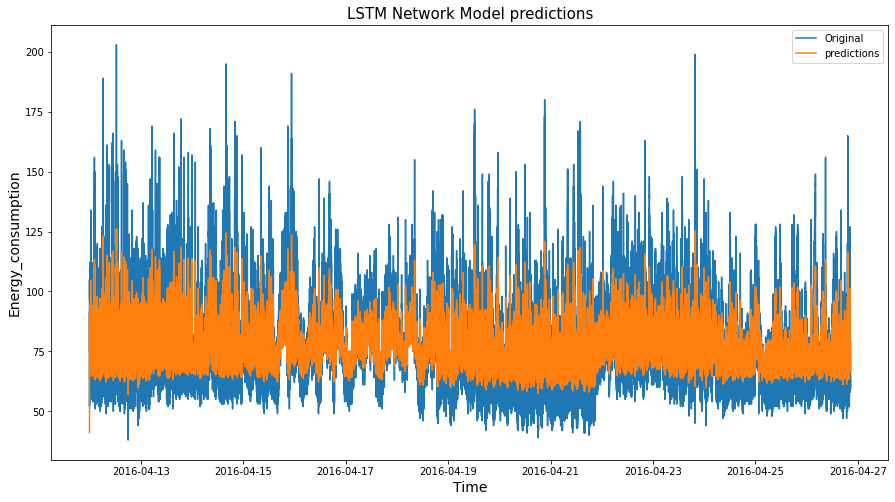

In [ ]:
main_lstm(124183, 100, 4, 0.6)

Starting Process
Transforming data to supervised data...
Train Size: 10 days 07:48:10
Prediction horizon: 4 days 12:40:40
Spliting data into train and test sets...
Scaling data...
Preparation Complete

Fitting model...
Parameters:
Epoch: 100
Batch size: 124183
Neurons: 4
Latency: 23.665207147598267S
3/3 [==============================] - 1s 17ms/step - loss: 0.0089
Evaluation
Mean square error: 0.00890421960502863
Fitting complete
---------------------------------------

RMSE: 60.60433150483849


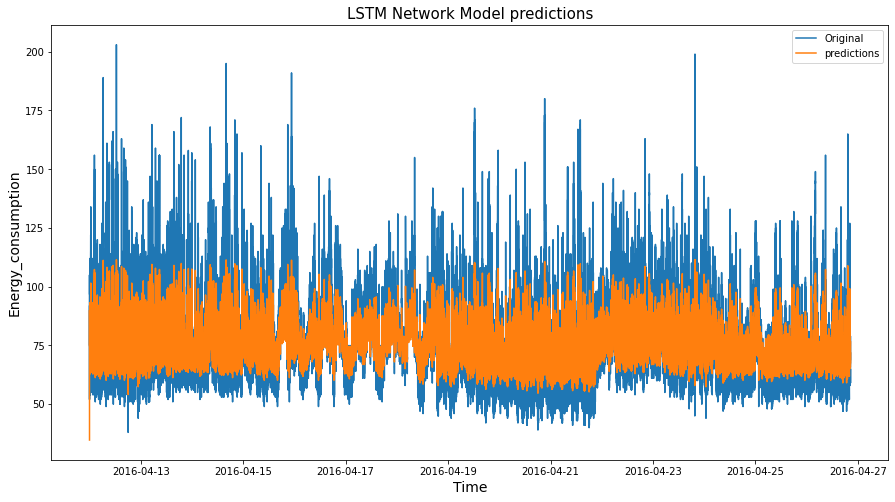

In [ ]:
main_lstm(124183, 100, 4, 0.7)

Starting Process
Transforming data to supervised data...
Train Size: 11 days 15:56:20
Prediction horizon: 3 days 04:32:30
Spliting data into train and test sets...
Scaling data...
Preparation Complete

Fitting model...
Parameters:
Epoch: 100
Batch size: 124183
Neurons: 4
Latency: 27.61184334754944S
2/2 [==============================] - 1s 23ms/step - loss: 0.0031
Evaluation
Mean square error: 0.0031095417216420174
Fitting complete
---------------------------------------

RMSE: 21.164316345460406


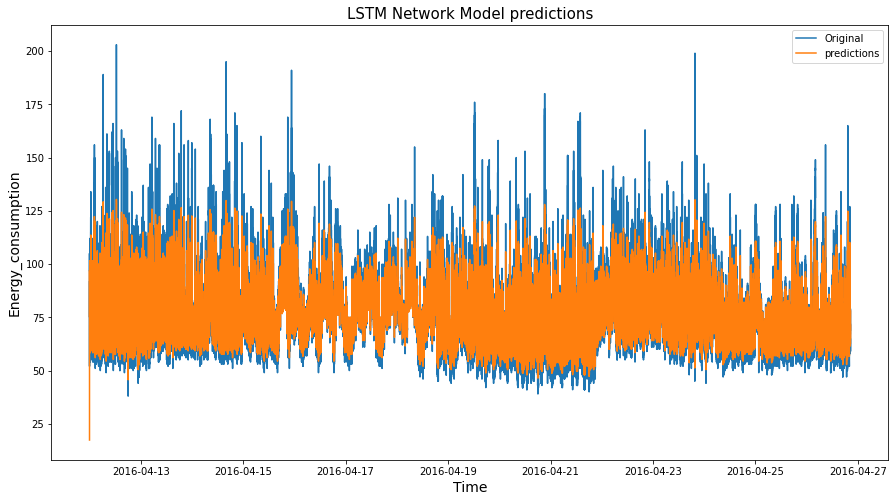

In [ ]:
main_lstm(124183, 100, 4, 0.8)

In [ ]:
t_size = int(len(lstm_df)*1)
kk=[i for i in range(1,t_size) if t_size%i==0]
kk

In [ ]:
t_size = int(len(lstm_df)*0.8)
kt=[i for i in range(1,t_size) if t_size%i==0]
kt

In [ ]:
t_size = int(len(lstm_df)*0.3)
[i for i in range(1,t_size) if t_size%i==0 and i in kk]

# END